In [1]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import ModelCheckpoint, Callback
import PIL
import warnings
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import glob
import sklearn
import tifffile as tiff
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import tensorflow as tf

# For TensorFlow 2.x (modern approach)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth and limit (6GB for 12GB card)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=6*1024)]  # 6GB limit
        )
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Configured GPU: {gpus[0]}")
    except RuntimeError as e:
        print(e)

Virtual devices cannot be modified after being initialized


In [4]:
color_dict = {0: (0, 0, 0),  # Black for background
              1: (255, 255, 255)}  # White for change

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.uint8)
    
    for i, cls in enumerate(color_dict):
        # Compare all 3 channels at once
        arr[..., i] = np.all(rgb_arr == color_dict[cls], axis=-1).astype(np.uint8)
    return arr

def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2] + (3,), dtype=np.uint8)
    for k in color_dict.keys():
        output[single_layer == k] = color_dict[k]
    return output

def get_dataset(X1_dir, X2_dir, y_dir):
    X1, X2, Y = [], [], []
    
    for d in range(len(X1_dir)):
        # Read images
        x1 = cv2.imread(X1_dir[d], cv2.IMREAD_COLOR)
        x2 = cv2.imread(X2_dir[d], cv2.IMREAD_COLOR)
        mask = cv2.imread(y_dir[d], cv2.IMREAD_COLOR)
        
        # Resize to 512x512 if needed
        if x1.shape[:2] != (512, 512):
            x1 = cv2.resize(x1, (512, 512), interpolation=cv2.INTER_LINEAR)
            x2 = cv2.resize(x2, (512, 512), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST_EXACT)
        
        # Convert BGR to RGB
        x1 = cv2.cvtColor(x1, cv2.COLOR_BGR2RGB)
        x2 = cv2.cvtColor(x2, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Convert mask to one-hot
        onehot = rgb_to_onehot(mask, color_dict)
        
        X1.append(x1)
        X2.append(x2)
        Y.append(onehot)
    
    # Stack and normalize images
    X1 = np.array(X1, dtype=np.float32) / 255.0
    X2 = np.array(X2, dtype=np.float32) / 255.0
    Y = np.array(Y, dtype=np.float32)
    
    return X1, X2, Y

In [5]:
DATASET_PATH = "Levir-CD/npy_files/"
X1_train = np.load(os.path.join(DATASET_PATH, 'X1_train.npy')).astype('float32') / 255.0
X2_train = np.load(os.path.join(DATASET_PATH, 'X2_train.npy')).astype('float32') / 255.0
y_train = np.load(os.path.join(DATASET_PATH, 'y_train.npy'))
X1_val = np.load(os.path.join(DATASET_PATH, 'X1_val.npy')).astype('float32') / 255.0
X2_val = np.load(os.path.join(DATASET_PATH, 'X2_val.npy')).astype('float32') / 255.0
y_val = np.load(os.path.join(DATASET_PATH, 'y_val.npy'))

# --- NEW: Inspect mask values ---
print("Unique values in y_train:", np.unique(y_train))  # Debug unexpected values

# --- FIX: Binarize masks first ---
y_train = (y_train > 0).astype(np.uint8)  # Convert all positive values to 1
y_val = (y_val > 0).astype(np.uint8)

# Now convert to one-hot
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

print("Final shapes:")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}")

Unique values in y_train: [  0 255]
Final shapes:
y_train: (445, 512, 512, 2), y_val: (64, 512, 512, 2)


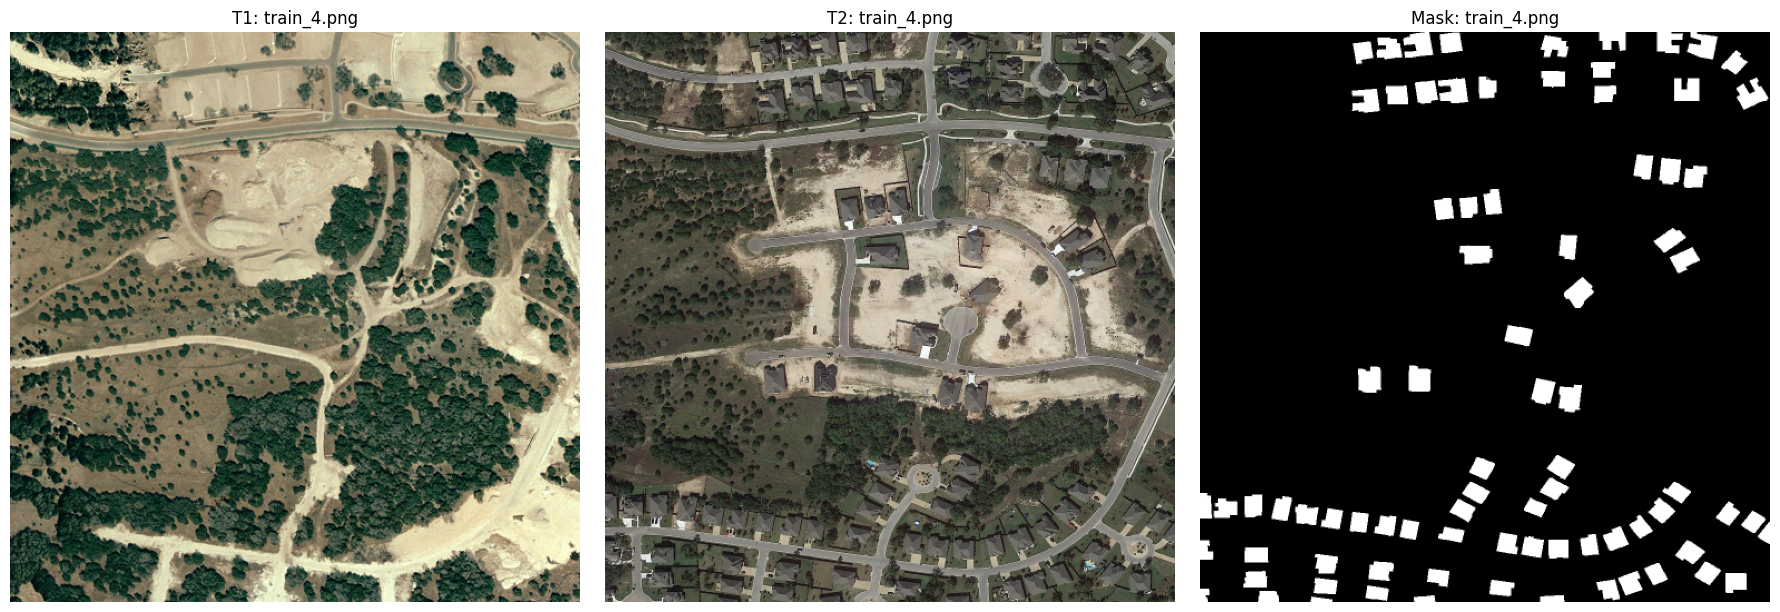

In [6]:
import cv2
import random
import matplotlib.pyplot as plt
import os

# Assuming these are defined (based on your previous structure)
DATASET_PATH = "Levir-CD/"
TRAIN_IMG1_DIR = os.path.join(DATASET_PATH, 'train/A/A')
TRAIN_IMG2_DIR = os.path.join(DATASET_PATH, 'train/B/B')
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, 'train/L/label')
IMG_SIZE = (512, 512)  # Changed from 1024 to 512

def display_example():
    # Get sorted lists to ensure matching pairs
    img1_files = sorted(os.listdir(TRAIN_IMG1_DIR))
    img2_files = sorted(os.listdir(TRAIN_IMG2_DIR))
    mask_files = sorted(os.listdir(TRAIN_MASK_DIR))
    
    idx = random.randint(0, len(img1_files) - 1)
    
    # Load images with error handling
    try:
        img1 = cv2.imread(os.path.join(TRAIN_IMG1_DIR, img1_files[idx]))
        img2 = cv2.imread(os.path.join(TRAIN_IMG2_DIR, img2_files[idx]))
        mask = cv2.imread(os.path.join(TRAIN_MASK_DIR, mask_files[idx]), cv2.IMREAD_GRAYSCALE)
        
        # Resize to 512x512 (if not already)
        img1 = cv2.resize(img1, IMG_SIZE)
        img2 = cv2.resize(img2, IMG_SIZE)
        mask = cv2.resize(mask, IMG_SIZE)
        
        # Display
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        plt.title(f'T1: {img1_files[idx]}')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        plt.title(f'T2: {img2_files[idx]}')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
        plt.title(f'Mask: {mask_files[idx]}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error loading image {idx}: {e}")

display_example()

In [7]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
import tensorflow.keras.backend as K
import tensorflow as tf

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    return focal_loss

def att_module(x):
    x1 = AveragePooling2D((x.shape[1], x.shape[1]), strides=None, padding="same")(x)
    x1 = Conv1D(x.shape[3], 3, padding='same', kernel_initializer='he_normal')(x1)  # Changed to he_normal
    x1 = Activation('sigmoid')(x1)
    x1 = Multiply()([x1,x])
    
    x2 = K.max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=3)
    x2 = Conv2D(x.shape[3], 3, padding='same', kernel_initializer='he_normal')(x2)  # Changed to he_normal
    x2 = Activation('sigmoid')(x2)
    x2 = Multiply()([x2,x])
    
    x = Add()([x1,x2])
    return x

def conv_block(x, f):
    c = Conv2D(f, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)  # Changed to he_normal
    c = Conv2D(f, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c)
    c = Conv2D(f, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c)
    return c

def conc_att_conv(x1, x2, x3, f):
    up = Conv2D(f, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2,2))(x2))
    merge = concatenate([x1, up, x3], axis=3)
    att = att_module(merge)
    x = conv_block(att, f)
    return x

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
    
def adsnet(shape=(512, 512, 3), deep_supervision=True):  # Changed from 1024 to 512
    
    # Input layers
    input_layer_1 = Input(shape)
    input_layer_2 = Input(shape)
    
    # Encoder
    conv1 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')
    c11 = conv1(input_layer_1)
    c21 = conv1(input_layer_2)
    
    pool11 = MaxPooling2D(pool_size=(2, 2))(c11)
    pool21 = MaxPooling2D(pool_size=(2, 2))(c21)
    
    conv2 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')
    c12 = conv2(pool11)
    c22 = conv2(pool21)
    
    pool12 = MaxPooling2D(pool_size=(2, 2))(c12)
    pool22 = MaxPooling2D(pool_size=(2, 2))(c22)   
    
    conv3 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')
    c13 = conv3(pool12)
    c23 = conv3(pool22)
    
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
    c13 = conv3(c13)
    c23 = conv3(c23)
    
    pool13 = MaxPooling2D(pool_size=(2, 2))(c13)
    pool23 = MaxPooling2D(pool_size=(2, 2))(c23)
    
    conv4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
    c14 = conv4(pool13)
    c24 = conv4(pool23)
    
    conv4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
    c14 = conv4(c14)
    c24 = conv4(c24)
    
    pool14 = MaxPooling2D(pool_size=(2, 2))(c14)
    pool24 = MaxPooling2D(pool_size=(2, 2))(c24)
    
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
    c15 = conv5(pool14)
    c25 = conv5(pool24)
    
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
    c15 = conv5(c15)
    c25 = conv5(c25)
    
    # Difference features
    c5 = c15-c25
    c4 = c14-c24
    c3 = c13-c23
    c2 = c12-c22
    
    # Decoder with attention
    merge5 = concatenate([c15,c5,c25], axis=3)
    att51 = att_module(merge5)
    c51 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(att51)
    c51 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c51)
    
    c52 = conc_att_conv(c14, c51, c24, 64)
    c53 = conc_att_conv(c13, c52, c23, 32)
    c54 = conc_att_conv(c12, c53, c22, 16)
    x3 = conc_att_conv(c11, c54, c21, 8)
    
    merge6 = concatenate([c14,c4,c24], axis=3)
    att61 = att_module(merge6)
    c61 = conv_block(att61, 64)
    c62 = conc_att_conv(c13, c61, c23, 32)
    c63 = conc_att_conv(c12, c62, c22, 16)
    x2 = conc_att_conv(c11, c63, c21, 8)
    
    merge7 = concatenate([c13,c3,c23], axis=3)
    att71 = att_module(merge7)
    c71 = conv_block(att71, 32)
    c72 = conc_att_conv(c12, c71, c22, 16)
    x4 = conc_att_conv(c11, c72, c21, 8)
    
    merge8 = concatenate([c12,c2,c22], axis=3)
    att81 = att_module(merge8)
    c81 = conv_block(att81, 16)
    x1 = conc_att_conv(c11, c81, c21, 8)
    
    # Output layers
    x1 = Conv2D(2, (1,1), activation='softmax', padding='same')(x1)
    x2 = Conv2D(2, (1,1), activation='softmax', padding='same')(x2)
    x3 = Conv2D(2, (1,1), activation='softmax', padding='same')(x3)    
    x4 = Conv2D(2, (1,1), activation='softmax', padding='same')(x4)
    
    # Model compilation
    if deep_supervision:
        model = Model([input_layer_1, input_layer_2], [x1, x2, x3, x4])
        model.compile(optimizer=Adam(lr=1e-4),
                      loss=[FocalLoss]*4,
                      metrics=[get_f1, 'accuracy'])
    else:
        model = Model([input_layer_1, input_layer_2], [x3])
        model.compile(optimizer=Adam(lr=1e-4), 
                      loss=FocalLoss,
                      metrics=['accuracy'])

    return model

# Create model
ads = adsnet(shape=(512, 512, 3))  # Explicit 512x512 input
ads.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 8)  224         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 8)  0           conv2d[0][0]                 

c:\Users\shyamlal\anaconda3\envs\Chiranth_K\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [8]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_PATH = os.path.join("Levir-CD", "saved_models", "adsnet3.h5")
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True) 

callbacks = [
    ModelCheckpoint(
        filepath=MODEL_SAVE_PATH,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
]

X1_train = X1_train.astype('float32') / 255.0
X2_train = X2_train.astype('float32') / 255.0
X1_val = X1_val.astype('float32') / 255.0
X2_val = X2_val.astype('float32') / 255.0
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

# For binary classification, you may want to threshold masks
# y_train = (y_train > 0).astype('float32')
# y_val = (y_val > 0).astype('float32')

ads.compile(optimizer=Adam(learning_rate=1e-4),
            loss=FocalLoss,
            metrics=[get_f1, 'accuracy'])

history = ads.fit(
    [X1_train, X2_train],
    y_train,  
    validation_data=([X1_val, X2_val], y_val),
    epochs=50,
    batch_size=1,  
    callbacks=callbacks
)

Epoch 1/50
445/445 [==============================] - 163s 322ms/step - loss: 0.2529 - conv2d_73_loss: 0.0578 - conv2d_74_loss: 0.0471 - conv2d_75_loss: 0.0982 - conv2d_76_loss: 0.0498 - conv2d_73_get_f1: 0.9541 - conv2d_73_accuracy: 0.9541 - conv2d_74_get_f1: 0.9540 - conv2d_74_accuracy: 0.9540 - conv2d_75_get_f1: 0.9523 - conv2d_75_accuracy: 0.9523 - conv2d_76_get_f1: 0.9525 - conv2d_76_accuracy: 0.9525 - val_loss: 0.1519 - val_conv2d_73_loss: 0.0402 - val_conv2d_74_loss: 0.0354 - val_conv2d_75_loss: 0.0399 - val_conv2d_76_loss: 0.0364 - val_conv2d_73_get_f1: 0.9580 - val_conv2d_73_accuracy: 0.9580 - val_conv2d_74_get_f1: 0.9580 - val_conv2d_74_accuracy: 0.9580 - val_conv2d_75_get_f1: 0.9580 - val_conv2d_75_accuracy: 0.9580 - val_conv2d_76_get_f1: 0.9580 - val_conv2d_76_accuracy: 0.9580

Epoch 00001: val_loss improved from inf to 0.15190, saving model to Levir-CD\saved_models\adsnet3.h5


c:\Users\shyamlal\anaconda3\envs\Chiranth_K\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
445/445 [==============================] - 154s 346ms/step - loss: 0.1499 - conv2d_73_loss: 0.0423 - conv2d_74_loss: 0.0360 - conv2d_75_loss: 0.0359 - conv2d_76_loss: 0.0358 - conv2d_73_get_f1: 0.9541 - conv2d_73_accuracy: 0.9541 - conv2d_74_get_f1: 0.9541 - conv2d_74_accuracy: 0.9541 - conv2d_75_get_f1: 0.9541 - conv2d_75_accuracy: 0.9541 - conv2d_76_get_f1: 0.9541 - conv2d_76_accuracy: 0.9541 - val_loss: 0.1403 - val_conv2d_73_loss: 0.0390 - val_conv2d_74_loss: 0.0348 - val_conv2d_75_loss: 0.0315 - val_conv2d_76_loss: 0.0350 - val_conv2d_73_get_f1: 0.9580 - val_conv2d_73_accuracy: 0.9580 - val_conv2d_74_get_f1: 0.9580 - val_conv2d_74_accuracy: 0.9580 - val_conv2d_75_get_f1: 0.9580 - val_conv2d_75_accuracy: 0.9580 - val_conv2d_76_get_f1: 0.9580 - val_conv2d_76_accuracy: 0.9580

Epoch 00002: val_loss improved from 0.15190 to 0.14027, saving model to Levir-CD\saved_models\adsnet3.h5
Epoch 3/50
445/445 [==============================] - 155s 347ms/step - loss: 0.1378 - conv2d_